## Imports

In [1]:
import inspect
import os  # paths para os scripts
import sys

sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src"))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src", "data"))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src", "features"))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src", "models"))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src", "visualization"))
import context as c  # shotscuts para os paths

In [16]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Separação Treino e Teste

In [3]:
df = pd.read_csv(c.DATA_PROCESSED_FLD/'datasetFinal.csv')

In [4]:
X, y = df.drop(['tr_win'], axis=1), df['tr_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (97928, 24)
X_test shape:  (24482, 24)


In [9]:
df_train,df_test = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
print(len(df_train))
print(len(df_test))

97928
24482


## Otimização de Parâmetros

In [6]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [8]:
params = {
    'n_estimators': (100, 600),
    'max_depth': (1, 10)
}  

In [9]:
def randomForest_hyper_parms(n_estimators, max_depth):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_features='sqrt',
                                   criterion='gini'
                                   )
    return np.mean(cross_val_score(model,X_train,y_train,cv=10,scoring='roc_auc'))

In [10]:
otimizacao = BayesianOptimization(f=randomForest_hyper_parms,pbounds = params,random_state=1)
otimizacao.maximize(n_iter=15, init_points=8, acq='ei')
parametros = otimizacao.max['params']

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.8302    | 4.753     | 460.2     |
| 2         | 0.7918    | 1.001     | 251.2     |
| 3         | 0.8088    | 2.321     | 146.2     |
| 4         | 0.8083    | 2.676     | 272.8     |
| 5         | 0.8298    | 4.571     | 369.4     |
| 6         | 0.8301    | 4.773     | 442.6     |
| 7         | 0.8088    | 2.84      | 539.1     |
| 8         | 0.7926    | 1.246     | 435.2     |
| 9         | 0.8299    | 4.544     | 460.0     |
| 10        | 0.8371    | 5.884     | 448.2     |
| 11        | 0.855     | 9.691     | 454.4     |
| 12        | 0.8512    | 8.571     | 356.7     |
| 13        | 0.7913    | 1.0       | 352.7     |
| 14        | 0.855     | 9.706     | 362.4     |
| 15        | 0.8551    | 9.908     | 475.6     |
| 16        | 0.859     | 10.0      | 483.2     |
| 17        | 0.7928    | 1.79      | 480.9     |
| 18        | 0.8551    | 9.094     | 490.2     |


## Treinamento de Modelo

In [6]:
clf_randomForest = RandomForestClassifier(n_estimators=int(483.2),
                                          max_depth=int(10),
                                          max_features='sqrt',
                                          criterion='gini')

In [7]:
clf_randomForest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=483)

In [33]:
clf_randomForest.score(X_train, y_train)

0.7723123110856956

## Métricas de Resultados

### Curva ROC

In [8]:
def evaluate_model(df_train,df_test,target,model,train_features):

    df_train['Probability'] = model.predict_proba(df_train[train_features])[:,1]
    df_test['Probability'] = model.predict_proba(df_test[train_features])[:,1]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))
    # Plot AUC Curve

    fpr_train, tpr_train, threshold_train = roc_curve(df_train[target], df_train['Probability'])
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, threshold_test = roc_curve(df_test[target], df_test['Probability'])
    roc_auc_test = auc(fpr_test, tpr_test)
    sns.set(font_scale=1.5) 
    title = 'Receiver Operating Characteristic (ROC) Curve' 
    ax = axes[0]
    ax.plot(fpr_train , tpr_train , color='darkorange', label = 'AUC = {}'.format(round(roc_auc_train,3))) 
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.legend(loc="lower right")
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.set_title('Train')

    ax = axes[1]
    ax.plot(fpr_test , tpr_test , color='darkorange', label = 'AUC = {}'.format(round(roc_auc_test,3))) 
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.legend(loc="lower right")
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.set_title('Validation')


    fig.suptitle(title)

In [18]:
features = df.drop(['tr_win'], axis=1).columns
features

Index(['ct_armor', 'ct_helmets', 't_helmets', 'ct_defuse_kits', 't_armor',
       'ct_grenade_flashbang', 'ct_players_alive', 'ct_grenade_smokegrenade',
       'ct_weapon_awp', 't_weapon_ak47', 'ct_health', 'bomb_planted',
       'ct_weapon_m4a4', 'ct_grenade_hegrenade',
       'ct_grenade_incendiarygrenade', 'ct_weapon_ak47', 't_grenade_flashbang',
       'ct_weapon_sg553', 't_weapon_sg553', 'ct_weapon_usps', 't_weapon_awp',
       't_players_alive', 't_grenade_smokegrenade', 't_weapon_usps'],
      dtype='object')

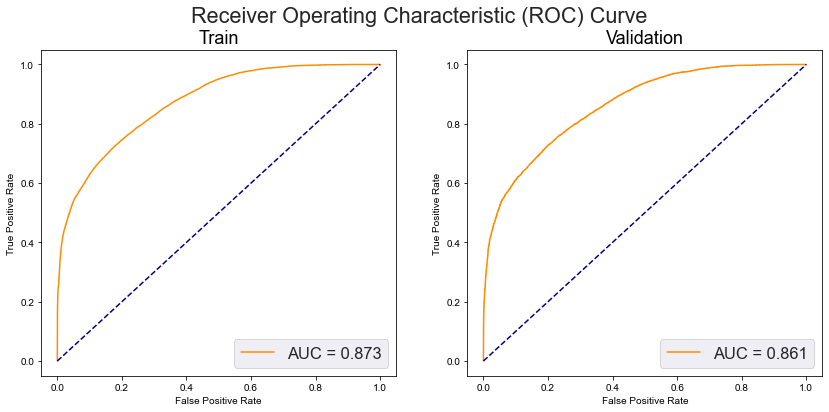

In [17]:
evaluate_model(df_train = df_train
               ,df_test = df_test
               ,target  =  'tr_win'
               ,model   = clf_randomForest
               ,train_features =  features)

### Matriz de confusão

In [19]:
def plot_matriz_confusao(y_true_teste, y_pred_teste, group_names=None,
                         categories='auto', count=True, cbar=True,
                         xyticks=True, sum_stats=True, figsize=None,
                         cmap='viridis', title=None):

    cf = confusion_matrix(y_true_teste, y_pred_teste)

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    box_labels = [f"{v1}{v2}".strip()
                  for v1, v2 in zip(group_labels, group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    if sum_stats:

        accuracy = accuracy_score(y_true_teste, y_pred_teste)
        precision = precision_score(y_true_teste, y_pred_teste)
        recall = recall_score(y_true_teste, y_pred_teste)
        f1_score_metric = f1_score(y_true_teste, y_pred_teste)

        stats_text = "\n\nAcurácia={:0.3f}\nPrecisão={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
            accuracy, precision, recall, f1_score_metric)
    else:
        stats_text = ""

    if figsize == None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        categories = False

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar,
                xticklabels=categories, yticklabels=categories)
    plt.ylabel('Valores verdadeiros', fontsize=16)
    plt.xlabel('Valores preditos' + stats_text, fontsize=16)

    if title:
        plt.title(title, fontsize=20)

In [29]:
y_pred_dt = clf_randomForest.predict(X_test)

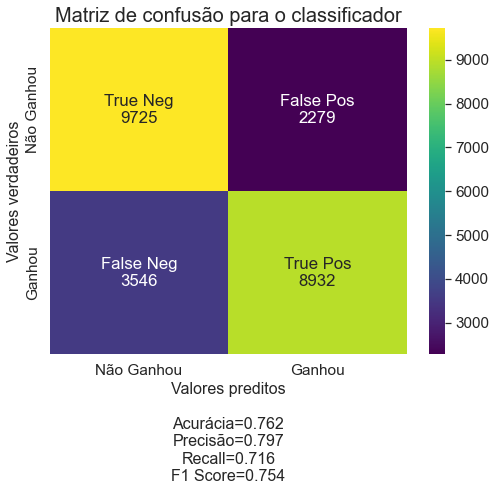

In [31]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Não Ganhou", "Ganhou"]
plot_matriz_confusao(y_test,
                      y_pred_dt,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6), 
                      title="Matriz de confusão para o classificador")